In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.time import Time
from astropy import units as u

matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

# Define Functions

In [2]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c

async def retrieve_rotator_angle_and_torques_from_efd(client, start, end):
    """
    Retrieves the Rotator Angle and the Motors torques from the EFD.
    
    Parameters
    ----------
    client : EfdClient
        Interface that allows querying data from the EFD.
    start : datetime string
        ISOT Time in UTC associated to the start of the data.
    end : datetime string
        ISOT Time in UTC associated to the end of the data.
        
    Returns
    -------
    _df : DataFrame
        Table containing the queried data.
    """
    _df_rotator = await client.select_time_series(
        'lsst.sal.MTRotator.rotation', 
        fields='actualPosition', 
        start=start, 
        end=end)

    _df_motors = await client.select_time_series(
        "lsst.sal.MTRotator.motors", 
        fields=['torque0', 'torque1', 'raw0', 'raw1', 'calibrated0', 'calibrated1'], 
        start=start, 
        end=end)

    _df = pd.merge(_df_rotator, _df_motors, left_index=True, right_index=True)
    _df = _df.dropna()
    
    return _df

# Get sal object Script messages from each test

In [3]:
#t_start = Time('2022-03-01T15:40:22.143140', scale='utc', format='isot') 
#t_end = Time('2022-03-01T18:52:17.886160', scale='utc', format='isot')
# Make a wide window covering all tests.

t_start = Time('2022-03-01T00:00', scale='utc', format='isot') 
t_end = Time('2022-04-30T00:00', scale='utc', format='isot')

In [4]:
summit = True
efd_client = retrieve_efd_client(summit)

In [5]:
# Get all of the tests in the wide time period that used our ScriptID of 42658886
# Also filter out the CSC start messages.

messages = await efd_client.select_time_series(
        "lsst.sal.Script.logevent_logMessage", 
        fields=['ScriptID','message'], 
        index = 42658886,
        start=t_start, 
        end=t_end)

messages = messages.query('message != "Read historical data in 0.00 sec"')
messages.reset_index(inplace=True)

In [6]:
# Change display.max_rows to None to see all rows
# Change display.max_colwidth to 400 to see whole line

with pd.option_context('display.max_rows', 10, 'display.max_colwidth', 120):
    display(messages)

,index,ScriptID,message
0,2022-03-01 15:40:22.143000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 15:40:22.143140 UTC
1,2022-03-01 15:40:31.330000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 15:40:31.329968 UTC
2,2022-03-01 16:16:43.756000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 16:16:43.755951 UTC
3,2022-03-01 16:26:45.725000+00:00,42658886,START -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 16:26:45.725091 UTC
4,2022-03-01 16:34:00.933000+00:00,42658886,END -- LVV-2261: Hexapod at 0 - Pathfinder Lines Not Pressurized -- End Time: 2022-03-01 16:34:00.933397 UTC
...,...,...,...
108,2022-04-12 17:18:35.255000+00:00,42658886,"END -- LVV-2261: Hexapod X=-6700, Y=-6700, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- End Time: 2022..."
109,2022-04-12 17:18:38.844000+00:00,42658886,"START -- LVV-2261: Hexapod X=0, Y=-10000, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- Starting Time: ..."
110,2022-04-12 17:27:54.822000+00:00,42658886,"END -- LVV-2261: Hexapod X=0, Y=-10000, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- End Time: 2022-04..."
111,2022-04-12 17:28:38.386000+00:00,42658886,"START -- LVV-2261: Hexapod X=0, Y=11400, Z=-10000, U=0, V=0, W=0 - Pathfinder Lines Pressurized -- Starting Time: 2..."


# Make a dataframe for the rotator data for each test.

In [7]:
# We don't know the conversion from torque to current.  USe this conversion factor.

CSC_factor = 1.0e6 #Mistaken factor in the CSC
torque_to_amps = CSC_factor * 4.6/1200 # current = torque * 4.6 Amp / 1200 N.m


In [8]:
# Examine the good tests by hand. Find the START/END pairs with no errors in between them.  This list comes from Holger manually inspecting
# the table of tests above.
#
# Make a dataframe for each.

tests = [6, 10, 16, 18, 20, 24, 26, 33, 
        40, 42, 43, 44, 45, 46, 49, 52, 54, 65, 67, # Only 'START' no 'END' for test
        71, 73, 75, 77, 79, 81, 83, 
        86,                                         # Only 'START' no 'END' for test
        97, 99, 101, 103, 105, 107, 109, 111]

# Start with an empty set of dataframes.
dfs = []


for i, test in enumerate(tests):
    
    print(f'{i} Test #{test} - {messages.message[test]:.130}')
    start_time = Time(messages['index'][test])
    stop_time = Time(messages['index'][test+1])
    
    maximum_test_time = 20 # minutes
    
    if ((stop_time - start_time).to_value('min') > maximum_test_time):
        print(f'More than {maximum_test_time} minutes. Probably missing an END message. ' +
              f'Setting stop_time to start_time + {maximum_test_time} minutes')
        stop_time = start_time + maximum_test_time*u.minute
        
    df = await retrieve_rotator_angle_and_torques_from_efd(efd_client, start_time, stop_time)
    new = df.assign(test = test) \
            .assign(delta_time = (stop_time - start_time).to_value('min') ) \
            .assign(current0 = lambda x: torque_to_amps*x.torque0) \
            .assign(current1 = lambda x: torque_to_amps*x.torque1) \
            .assign(net_torque = lambda x: torque_to_amps*(x.torque0 + x.torque1))
       
    #new = new.resample('100L').mean() # Resample in 1 second intervals
    dfs.append(new)

# Reset all the times to start at the first test
zero_time = dfs[0].index[0]
      
for i, test in enumerate(tests):
   dfs[i].index = dfs[i].index - to_offset(dfs[i].index[0] - zero_time)

0 Test #6 - START -- LVV-2261: Hexapod u=-0.36deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:11:13.165259 UTC
1 Test #10 - START -- LVV-2261: Hexapod u=-0.18deg v=-0.18deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:31:42.666555 U
2 Test #16 - START -- LVV-2261: Hexapod u=-0.25deg v=-0.25deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 17:4
3 Test #18 - START -- LVV-2261: Hexapod u=+0.36deg v=0.00deg - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 18:00:45.600340 UT
4 Test #20 - START -- LVV-2261: Hexapod u=+0.253deg v=-0.253deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 18
5 Test #24 - START -- LVV-2261: Hexapod u=+0deg v=-0.36deg (total 0.36) - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 18:43:4
6 Test #26 - START -- LVV-2261: Hexapod x=-11400, Y=0, Z=-10330 - Pathfinder Lines Not Pressurized -- Starting Time: 2022-03-01 20:46:15.432952
7 

In [9]:
%%script echo Skipping Cell

# Use this to look at a dataframe

index = 30

print(f'Test #{tests[index]} - {messages.message[tests[index]]}')
display(dfs[index])

Skipping Cell


In [10]:
#%%script echo Skipping Cell

# Use this to print the tests and how many entries there are in each test

for i, test in enumerate(tests):
    print(f'{i:3d} {test:3d} {dfs[i].delta_time[0]:10.2f} {len(dfs[i]):8d}')

  0   6      15.27    14789
  1  10      10.85    10465
  2  16      13.30    12755
  3  18      12.94    12574
  4  20      13.22    12710
  5  24       8.59     8255
  6  26      14.23    13750
  7  33      10.27     9880
  8  40       7.59     6064
  9  42       5.93     5742
 10  43      20.00    19152
 11  44       7.42     7142
 12  45       5.05     4830
 13  46       6.76     6543
 14  49      12.98    12460
 15  52       3.64     3454
 16  54       5.72     5474
 17  65      15.30    10441
 18  67      20.00    19063
 19  71       4.95     4772
 20  73       3.94     3787
 21  75      13.11    12626
 22  77       5.70     5485
 23  79      20.00    17399
 24  81       8.87     8598
 25  83       3.69     3598
 26  86      20.00    17394
 27  97       5.55     5406
 28  99       5.52     5304
 29 101       6.52     6332
 30 103       9.58     9192
 31 105       7.05     6843
 32 107       7.42     7205
 33 109       9.27     8885
 34 111       6.09     6058


# Make Plots

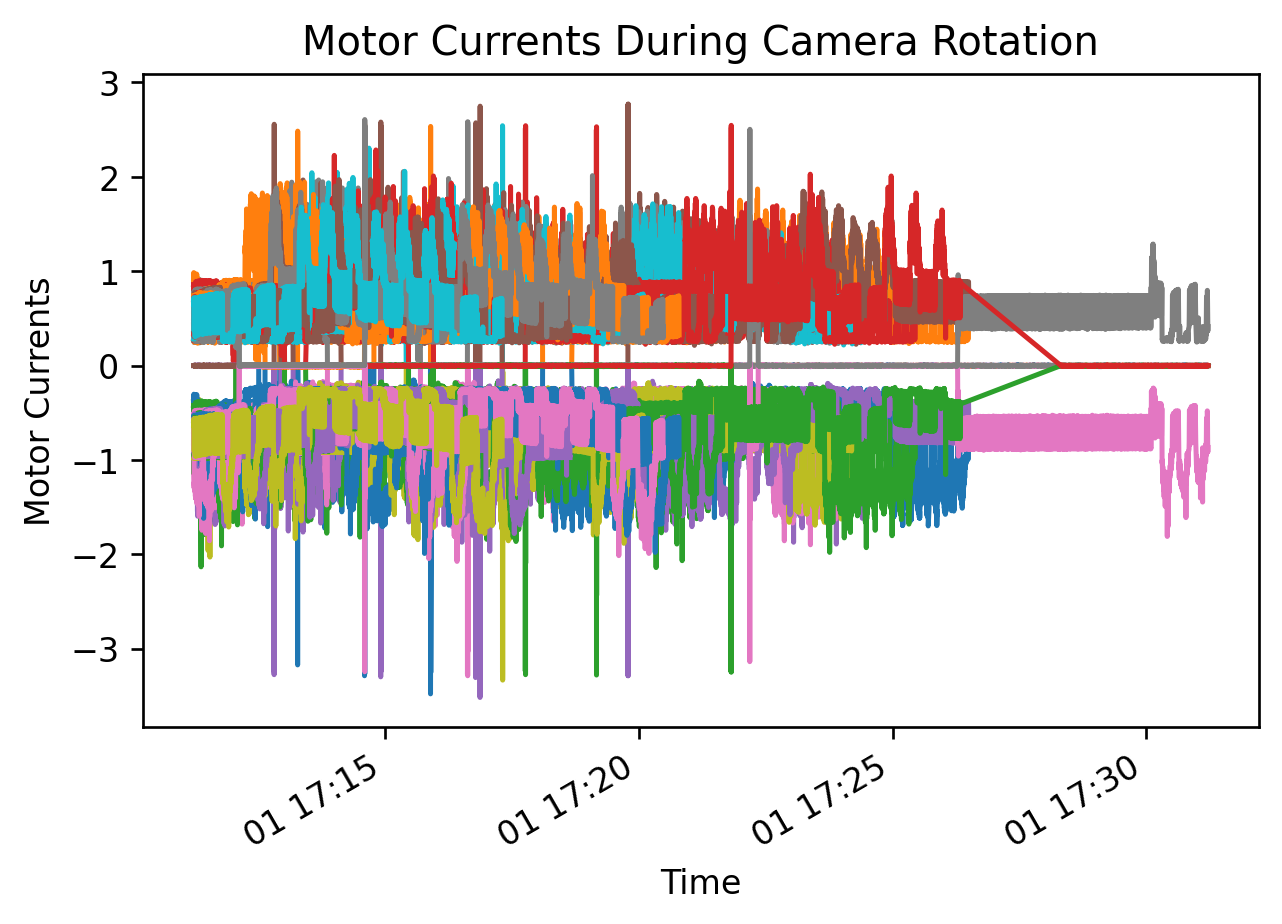

In [11]:
for i, test in enumerate(tests):
    dfs[i].current0.plot(label=f'{tests[i]}')
    dfs[i].current1.plot(label=f'{tests[i]}')
    
plt.title(r'Motor Currents During Camera Rotation')
plt.xlabel(r'Time')
plt.ylabel(r'Motor Currents');
#plt.legend(ncol=2, loc='lower left', fontsize=8)


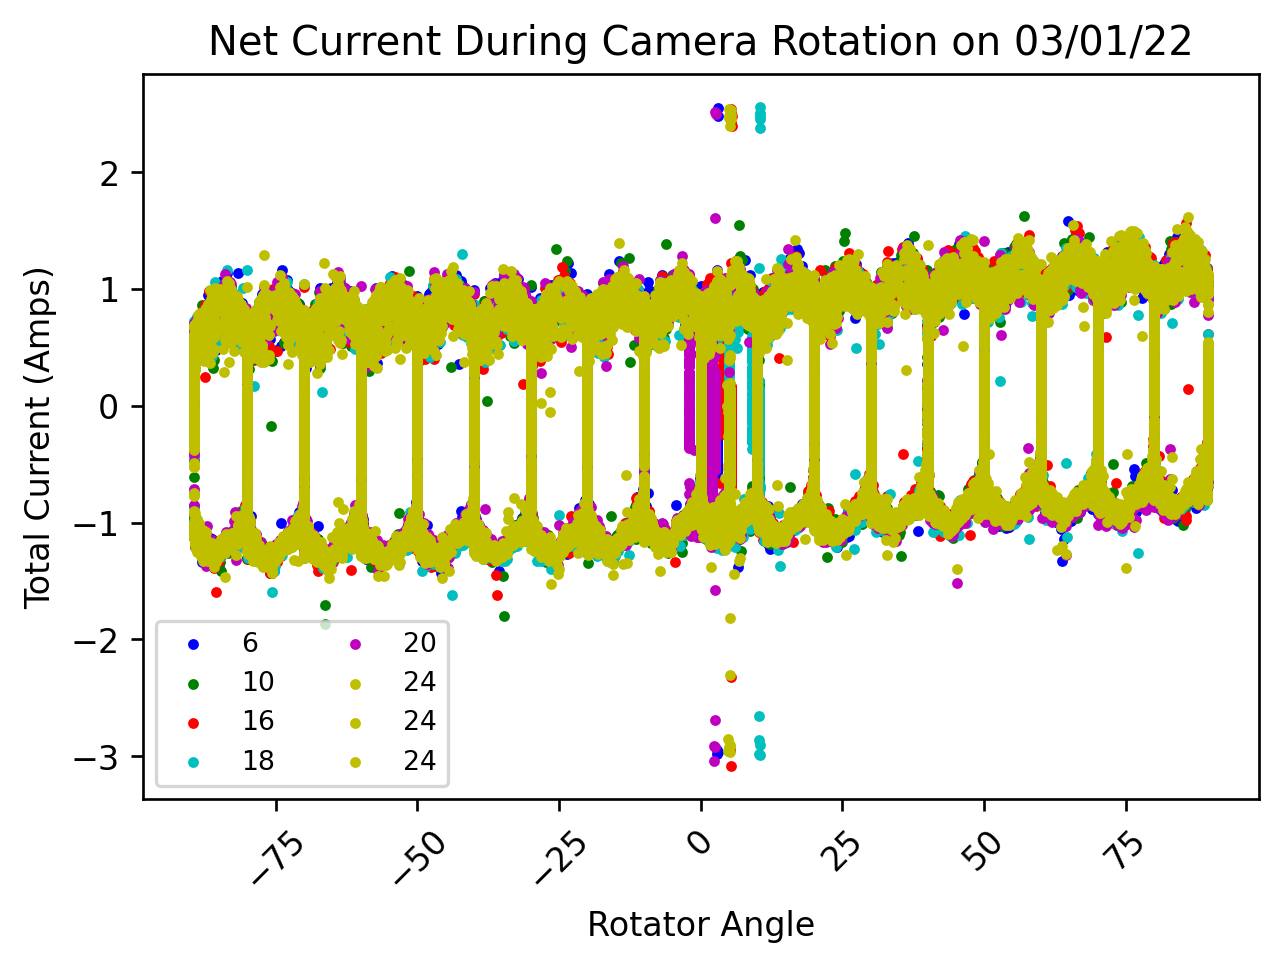

In [12]:
ax1 = dfs[0].plot.scatter('actualPosition', 'net_torque', marker=".", color='b', s=20.0, label=f'{tests[0]}')
ax2 = dfs[1].plot.scatter('actualPosition', 'net_torque', marker=".", color='g', s=20.0, ax=ax1, label=f'{tests[1]}')
ax3 = dfs[2].plot.scatter('actualPosition', 'net_torque', marker=".", color='r', s=20.0, ax=ax1, label=f'{tests[2]}')
ax4 = dfs[3].plot.scatter('actualPosition', 'net_torque', marker=".", color='c', s=20.0, ax=ax1, label=f'{tests[3]}')
ax5 = dfs[4].plot.scatter('actualPosition', 'net_torque', marker=".", color='m', s=20.0, ax=ax1, label=f'{tests[4]}')
ax6 = dfs[5].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')
ax7 = dfs[6].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')
ax8 = dfs[7].plot.scatter('actualPosition', 'net_torque', marker=".", color='y', s=20.0, ax=ax1, label=f'{tests[5]}')


plt.title(r'Net Current During Camera Rotation on 03/01/22')
#plt.ylim(-.001, .001)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Total Current (Amps)');

plt.legend(ncol=2, loc='lower left', fontsize=8)

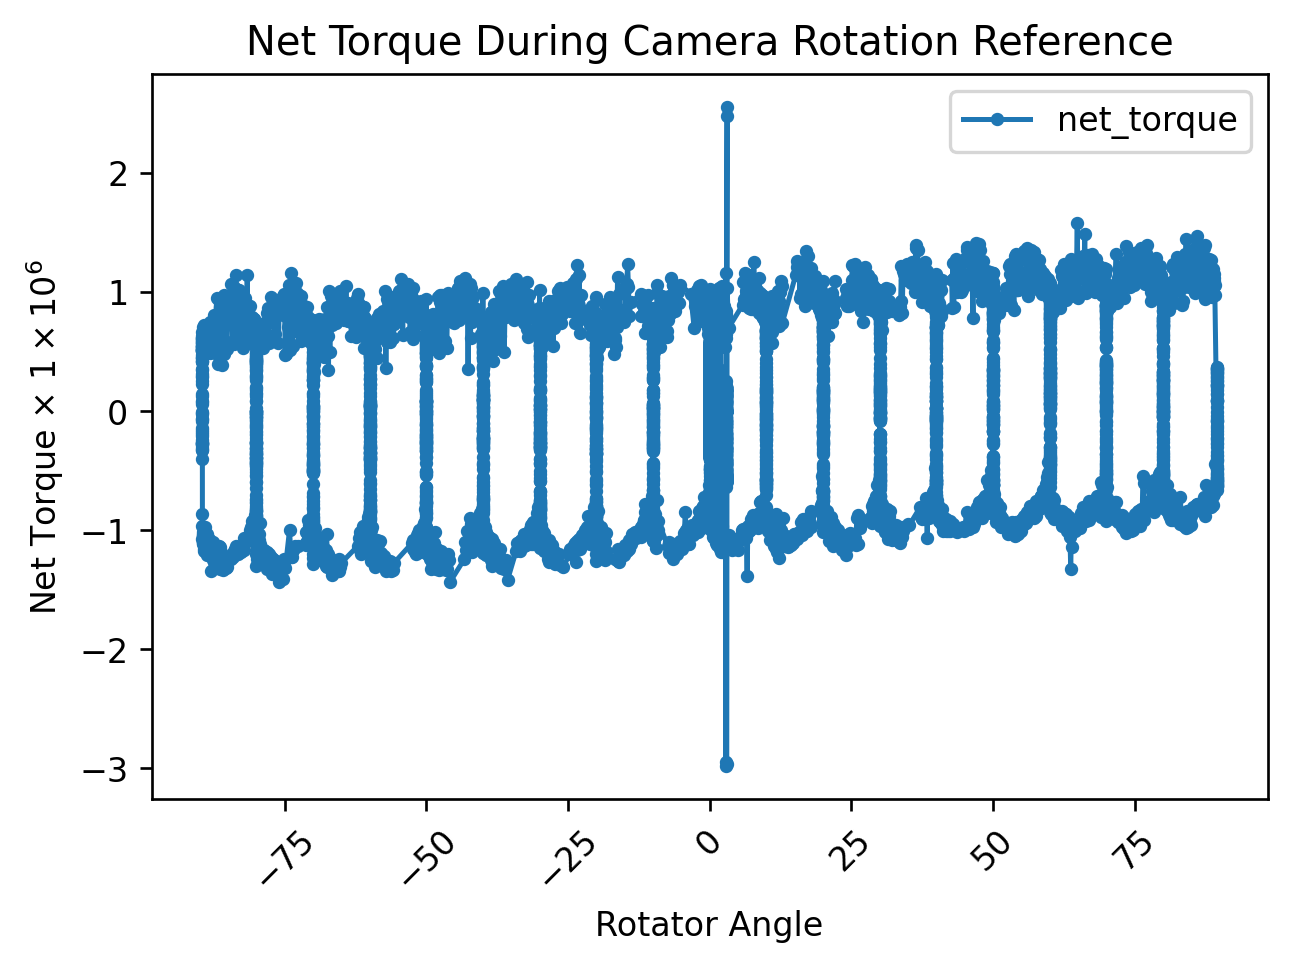

In [13]:
dfs[0].plot('actualPosition', 'net_torque', marker='.')

plt.title(r'Net Torque During Camera Rotation Reference')
#plt.xlim(-90, 0)
#plt.ylim(-1000, 1000)

plt.xticks(rotation=45)
plt.xlabel(r'Rotator Angle')
plt.ylabel(r'Net Torque $\times$ $1 \times 10^6$');

In [39]:
def draw_rotator_tests(title, layout, test_start, test_stop):
    '''
    Draw a set of rotator tests on a given day. Show the motor currents vs time. 
    '''
    
    fig, axes = plt.subplot_mosaic(layout, sharex=True, sharey=True, constrained_layout=True, figsize=(11, 8))

    for i, test in enumerate(range(test_start, test_stop+1)):
        #print(i, test, tests[test], layout.replace('\n','')[i])
        
        # Draw the current for the two motors
        cell = layout.replace('\n','')[i]
        dfs[test].current0.plot(ax=axes[cell])
        dfs[test].current1.plot(ax=axes[cell])
        
        # Draw current limits 
        axes[cell].set_ylim(-5,5)
        axes[cell].axhline(4.6, linestyle='--', color='magenta')
        axes[cell].axhline(-4.6, linestyle='--', color='magenta')
        
        # Make 2nd y-axis on right for rotator position
        axes2 = axes[cell].twinx()
        axes2.set_yticks([])
        dfs[test].actualPosition.plot(ax=axes2, color='green')
        axes2.set_ylim(-90,90)
    
    fig.suptitle(title)
    fig.supxlabel("Time")
    fig.supylabel("Motor Current (Amps)")

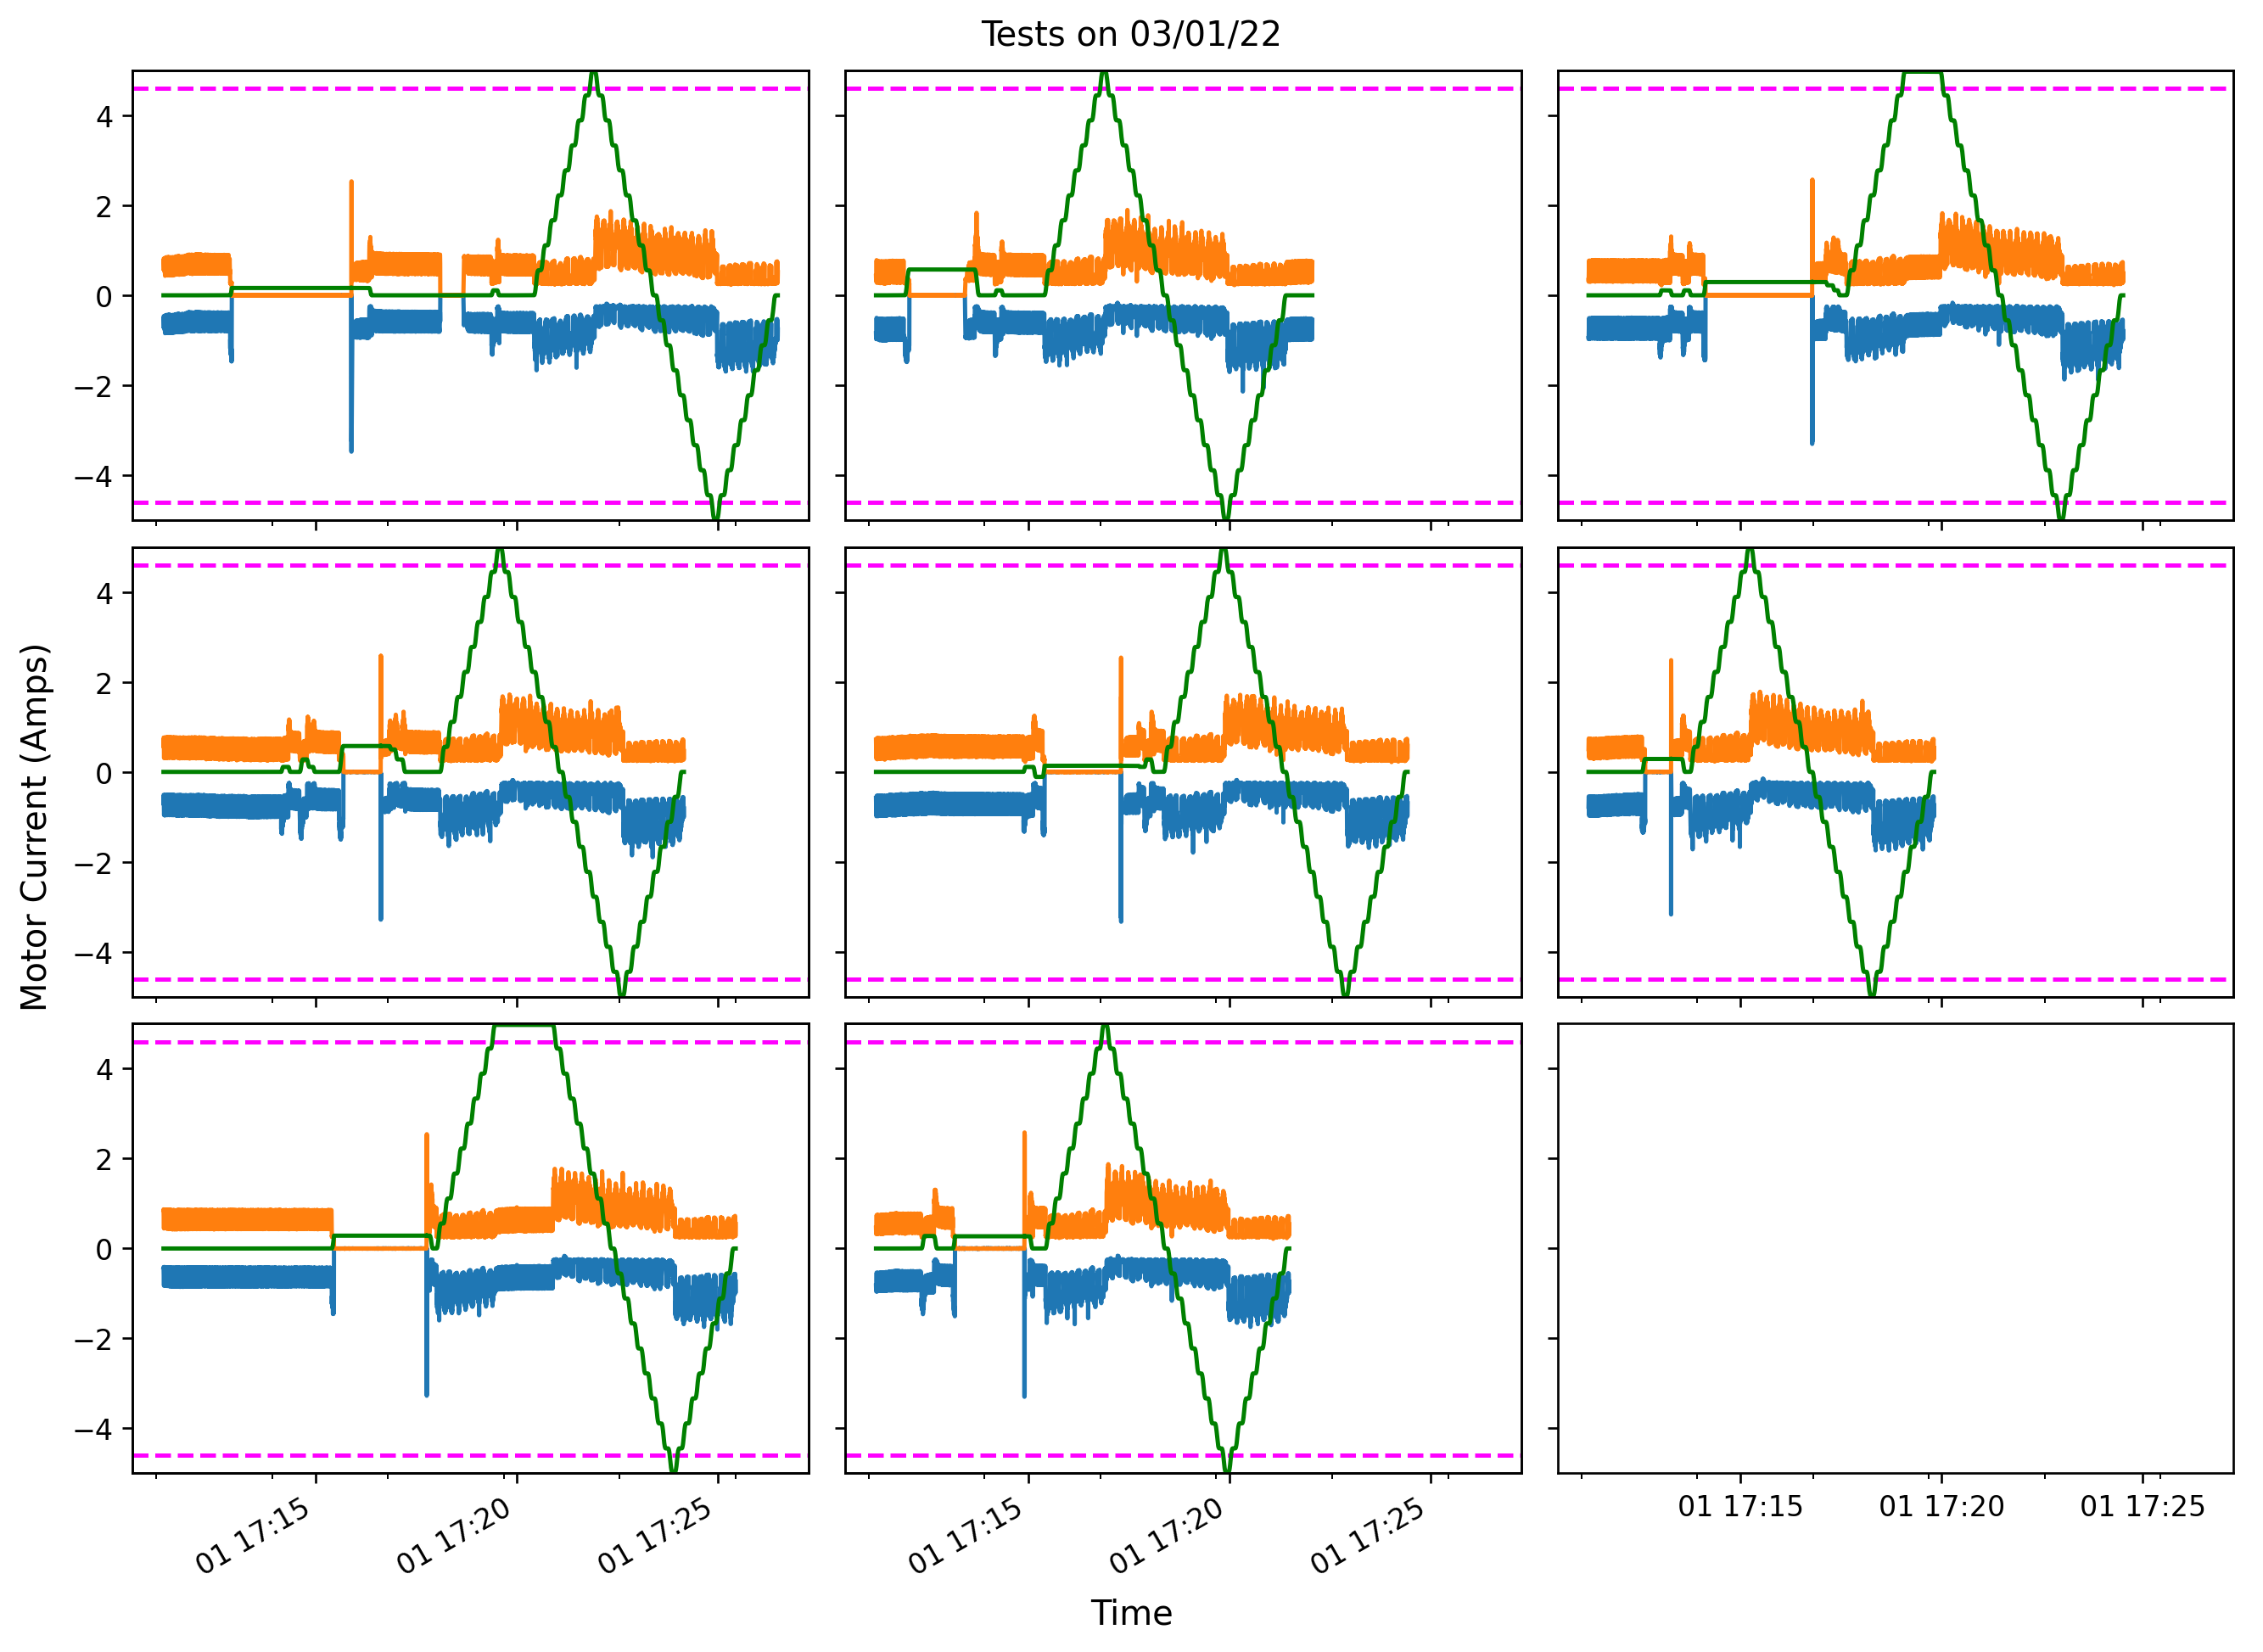

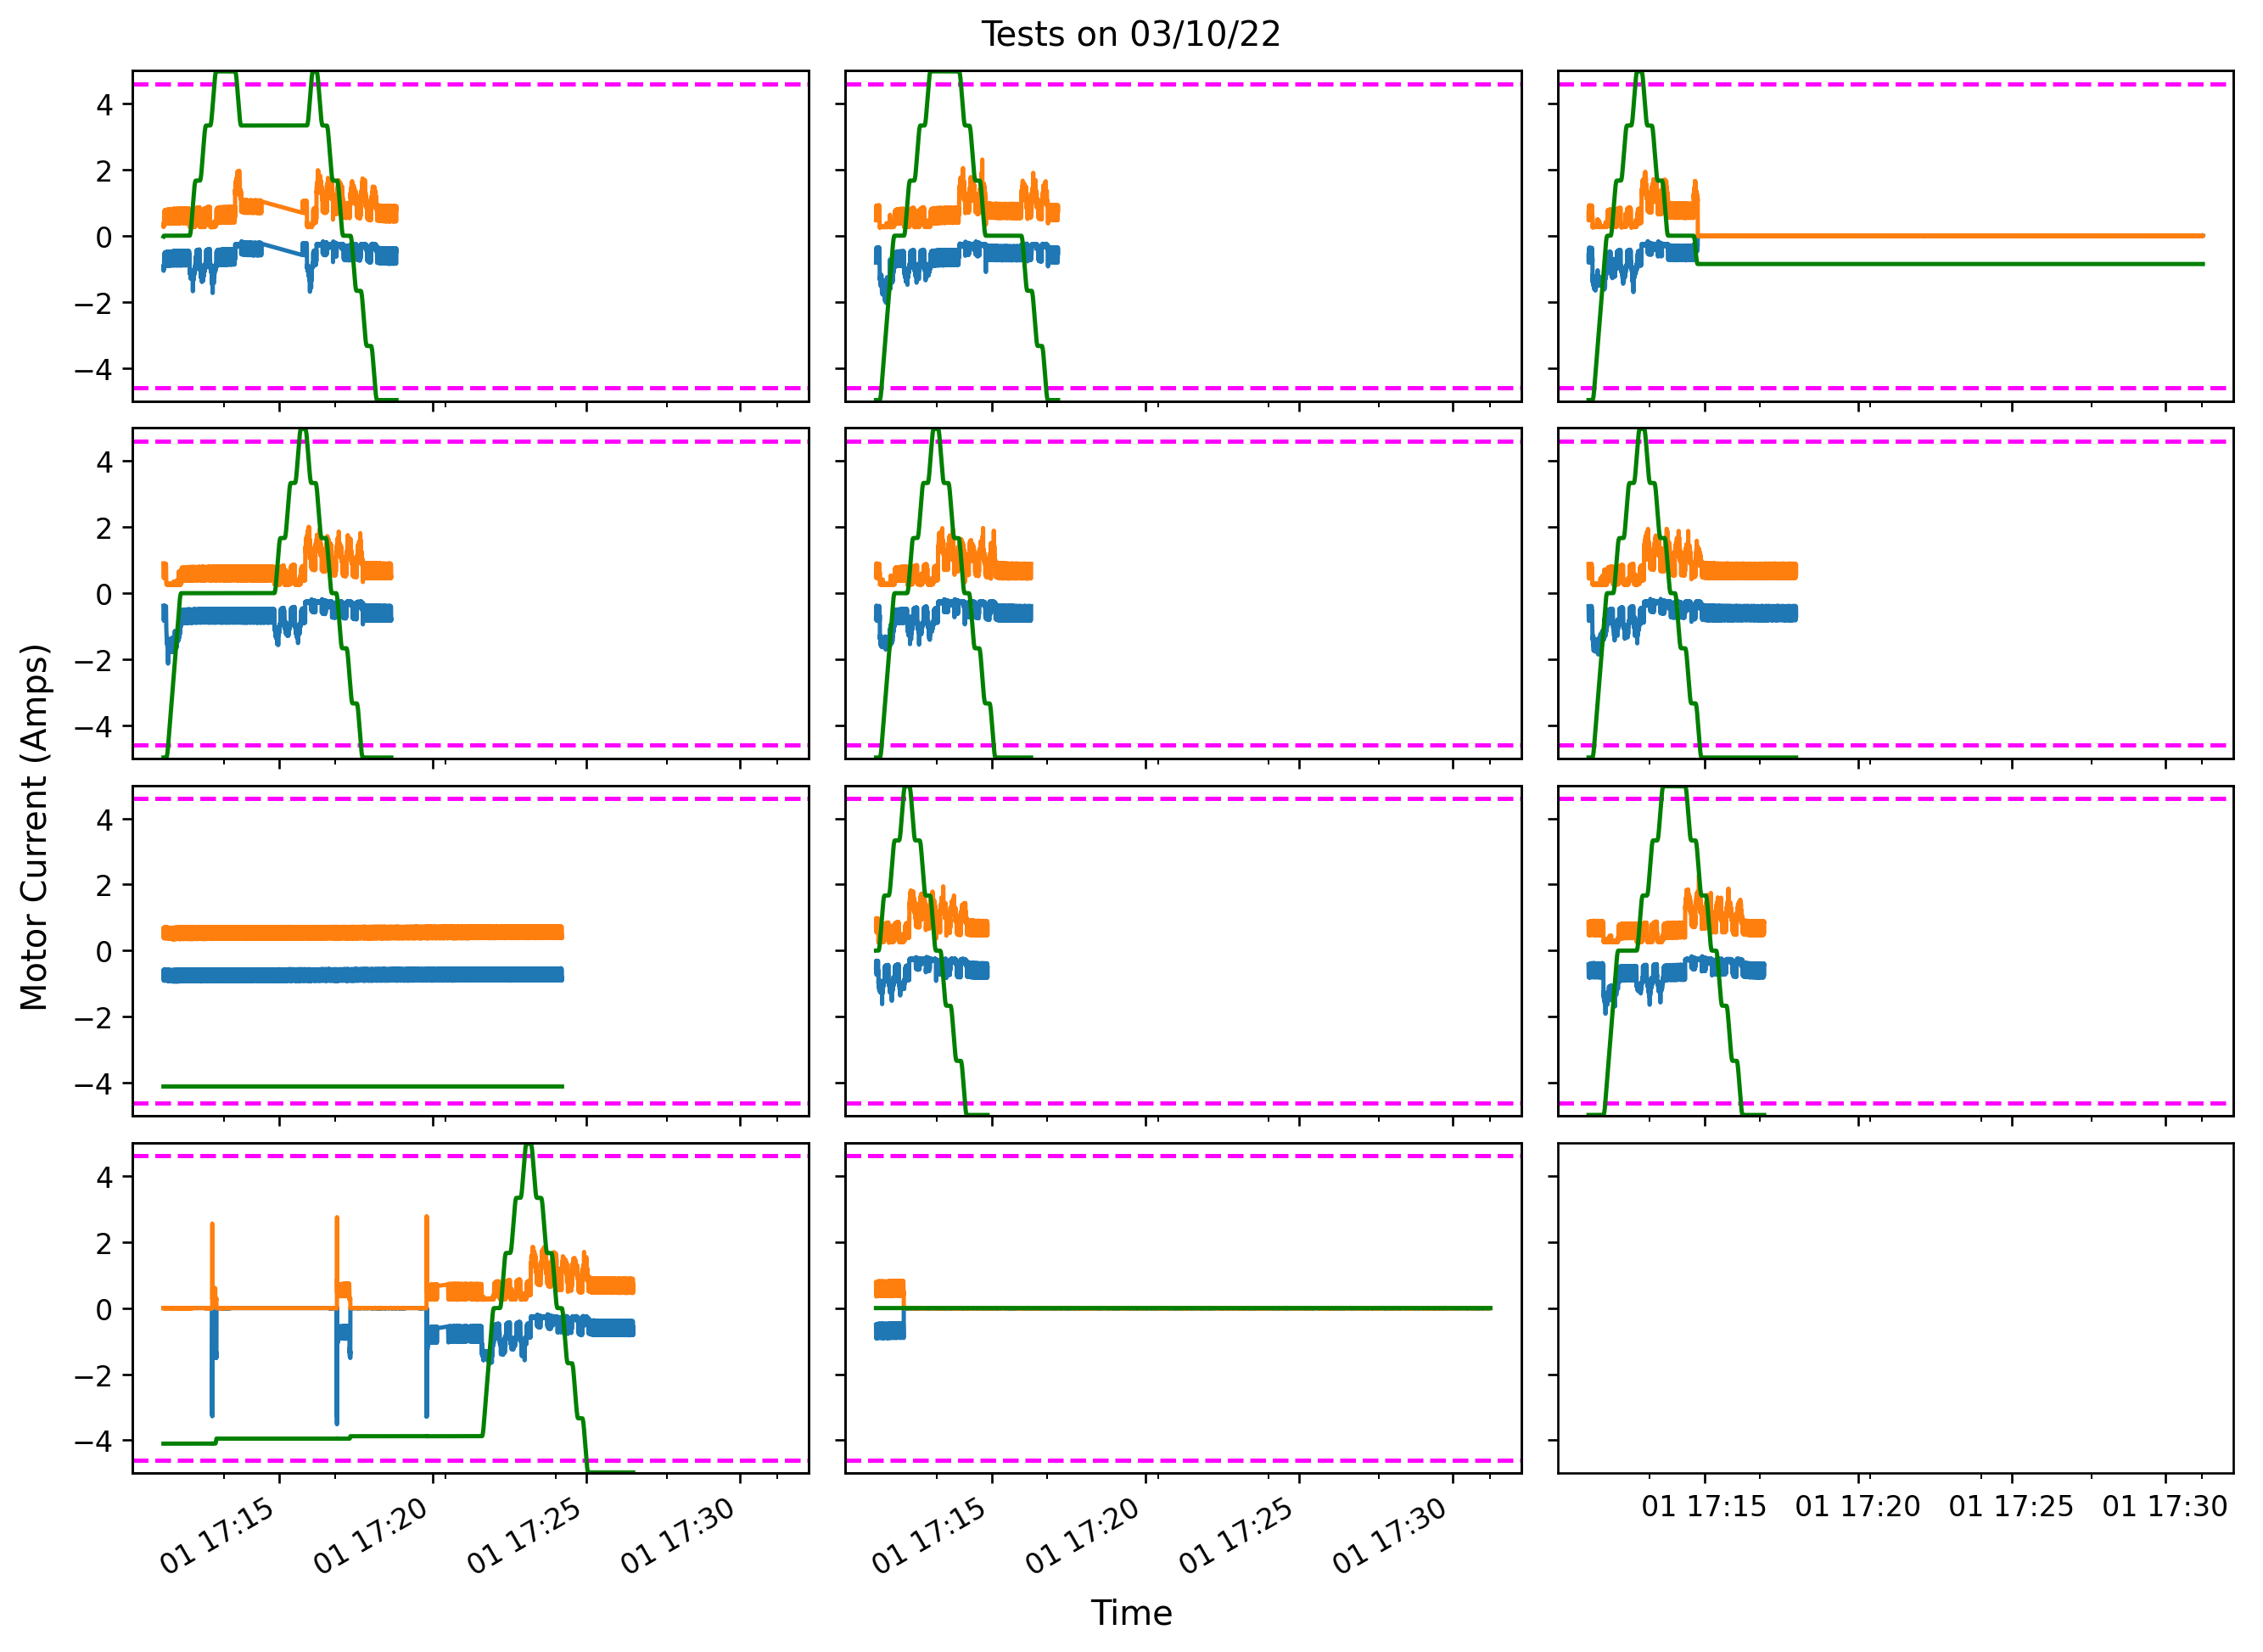

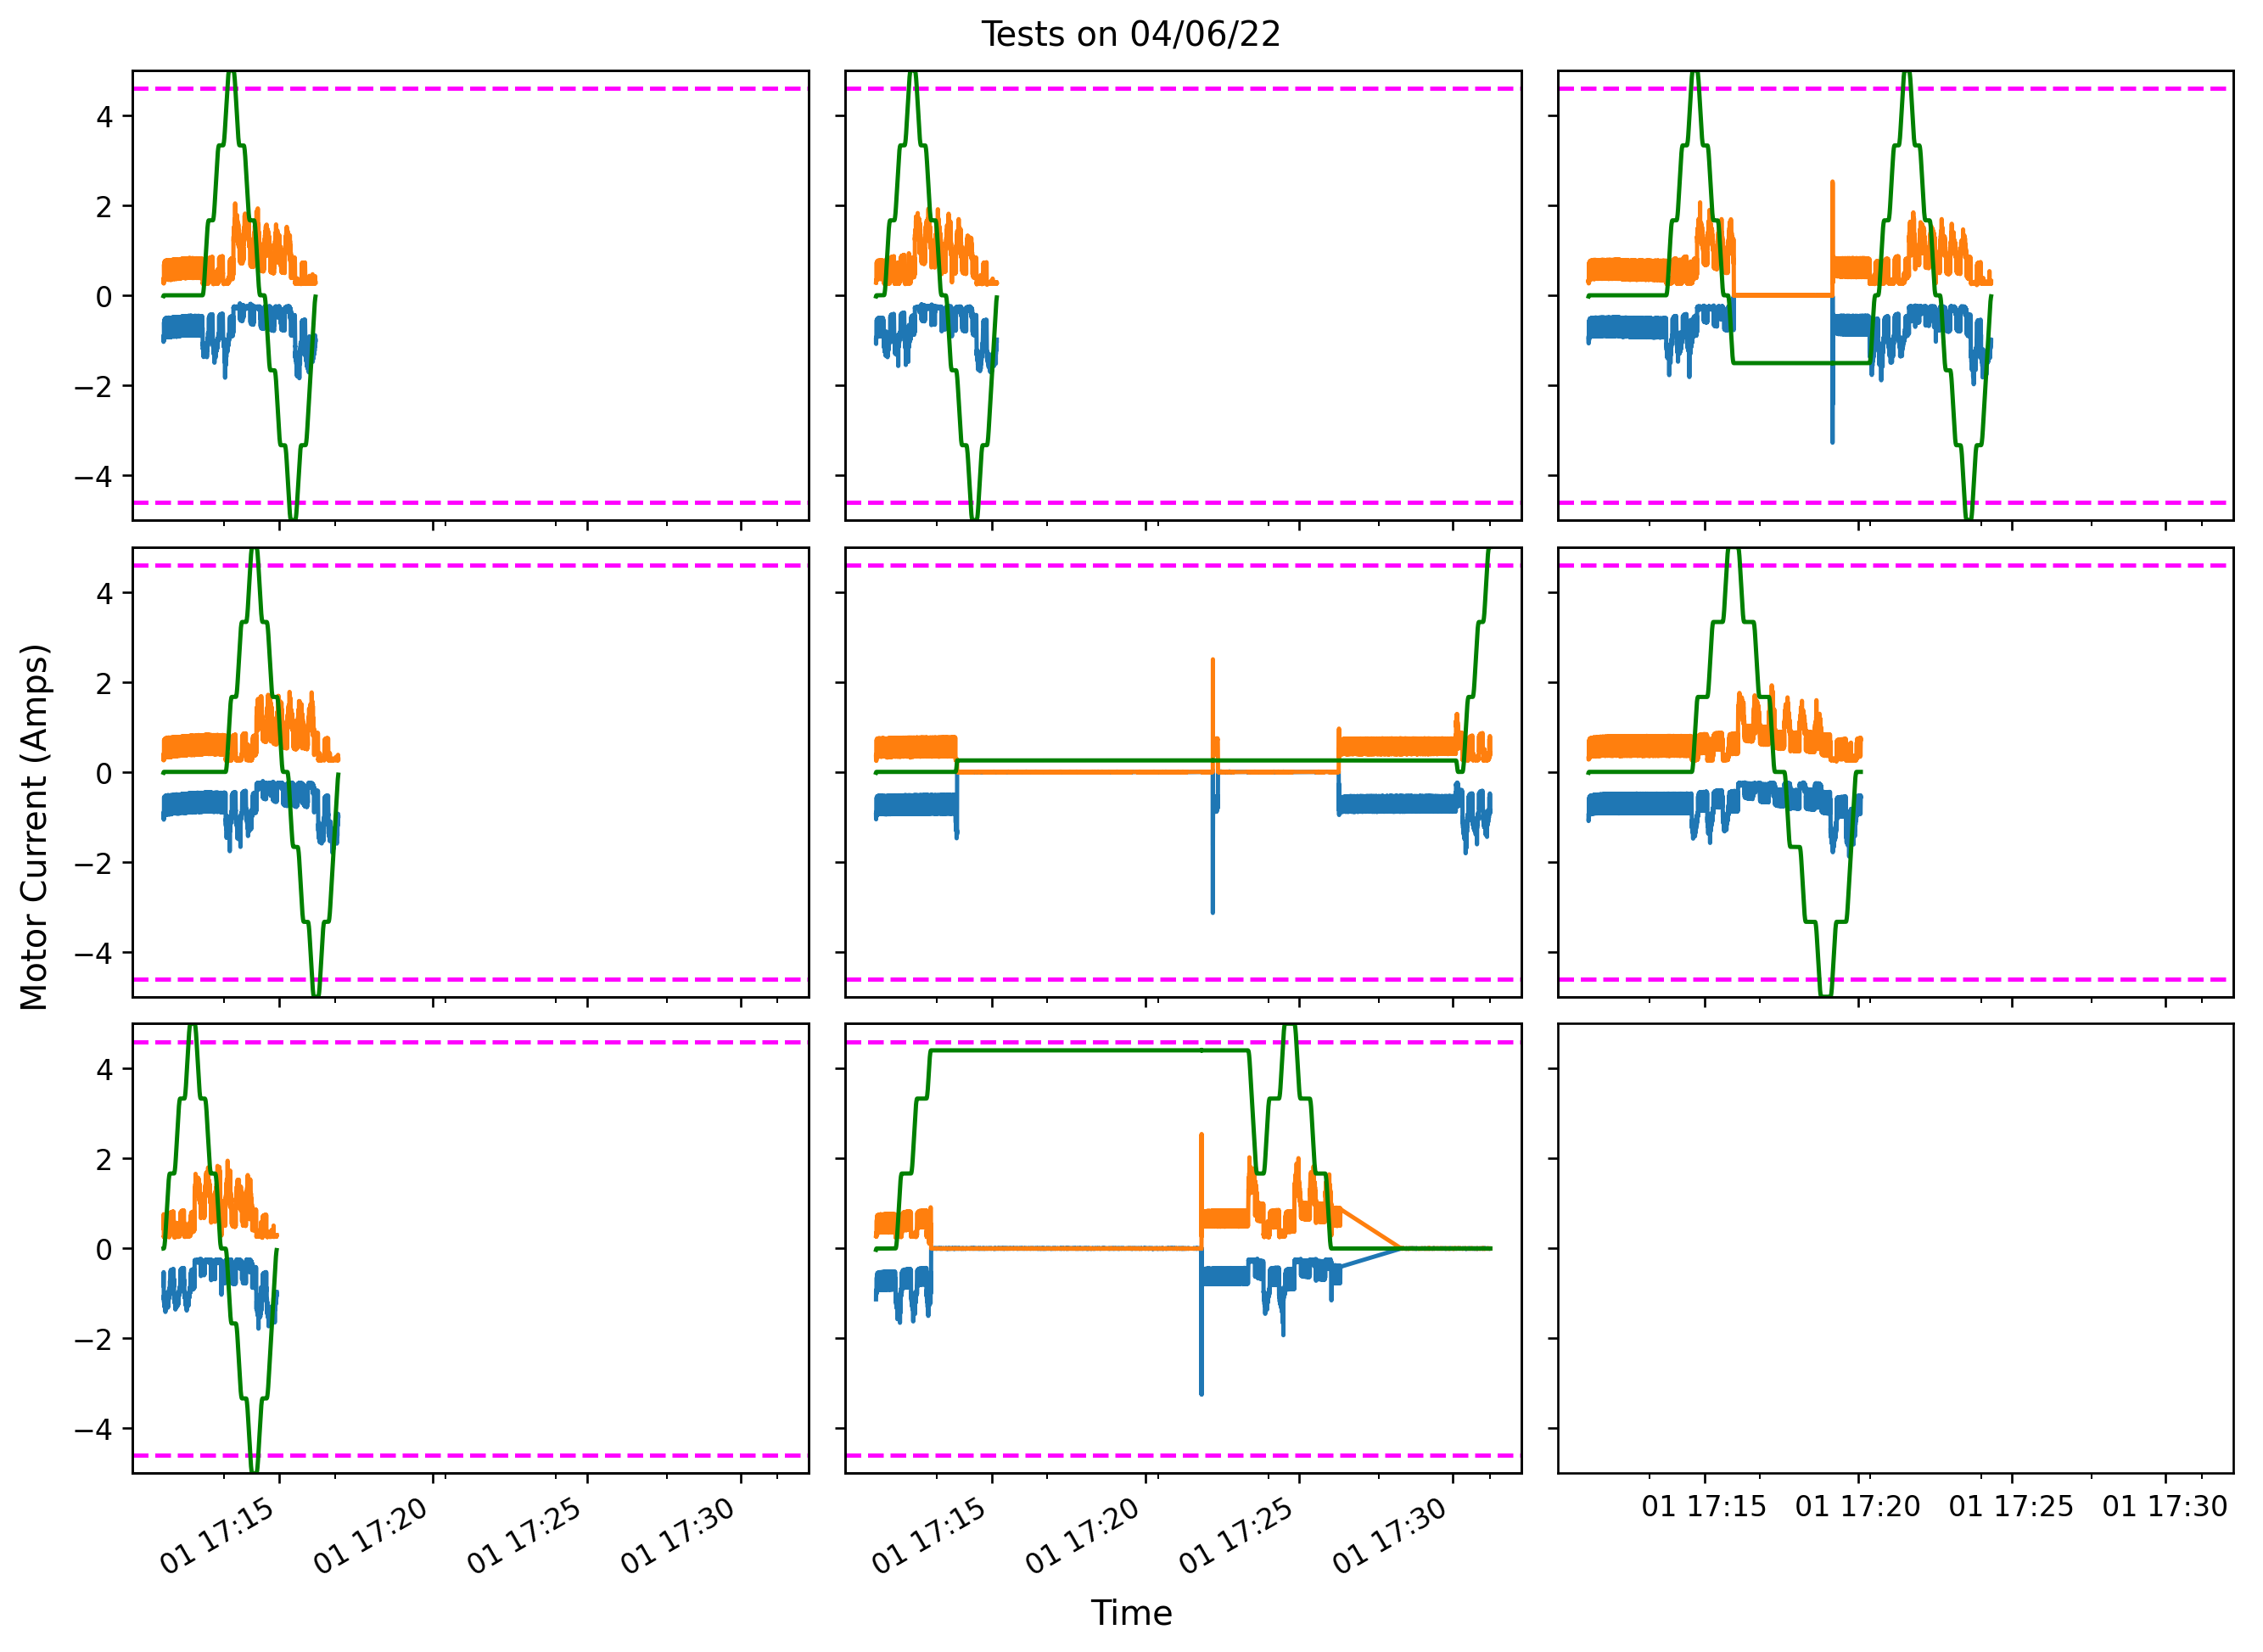

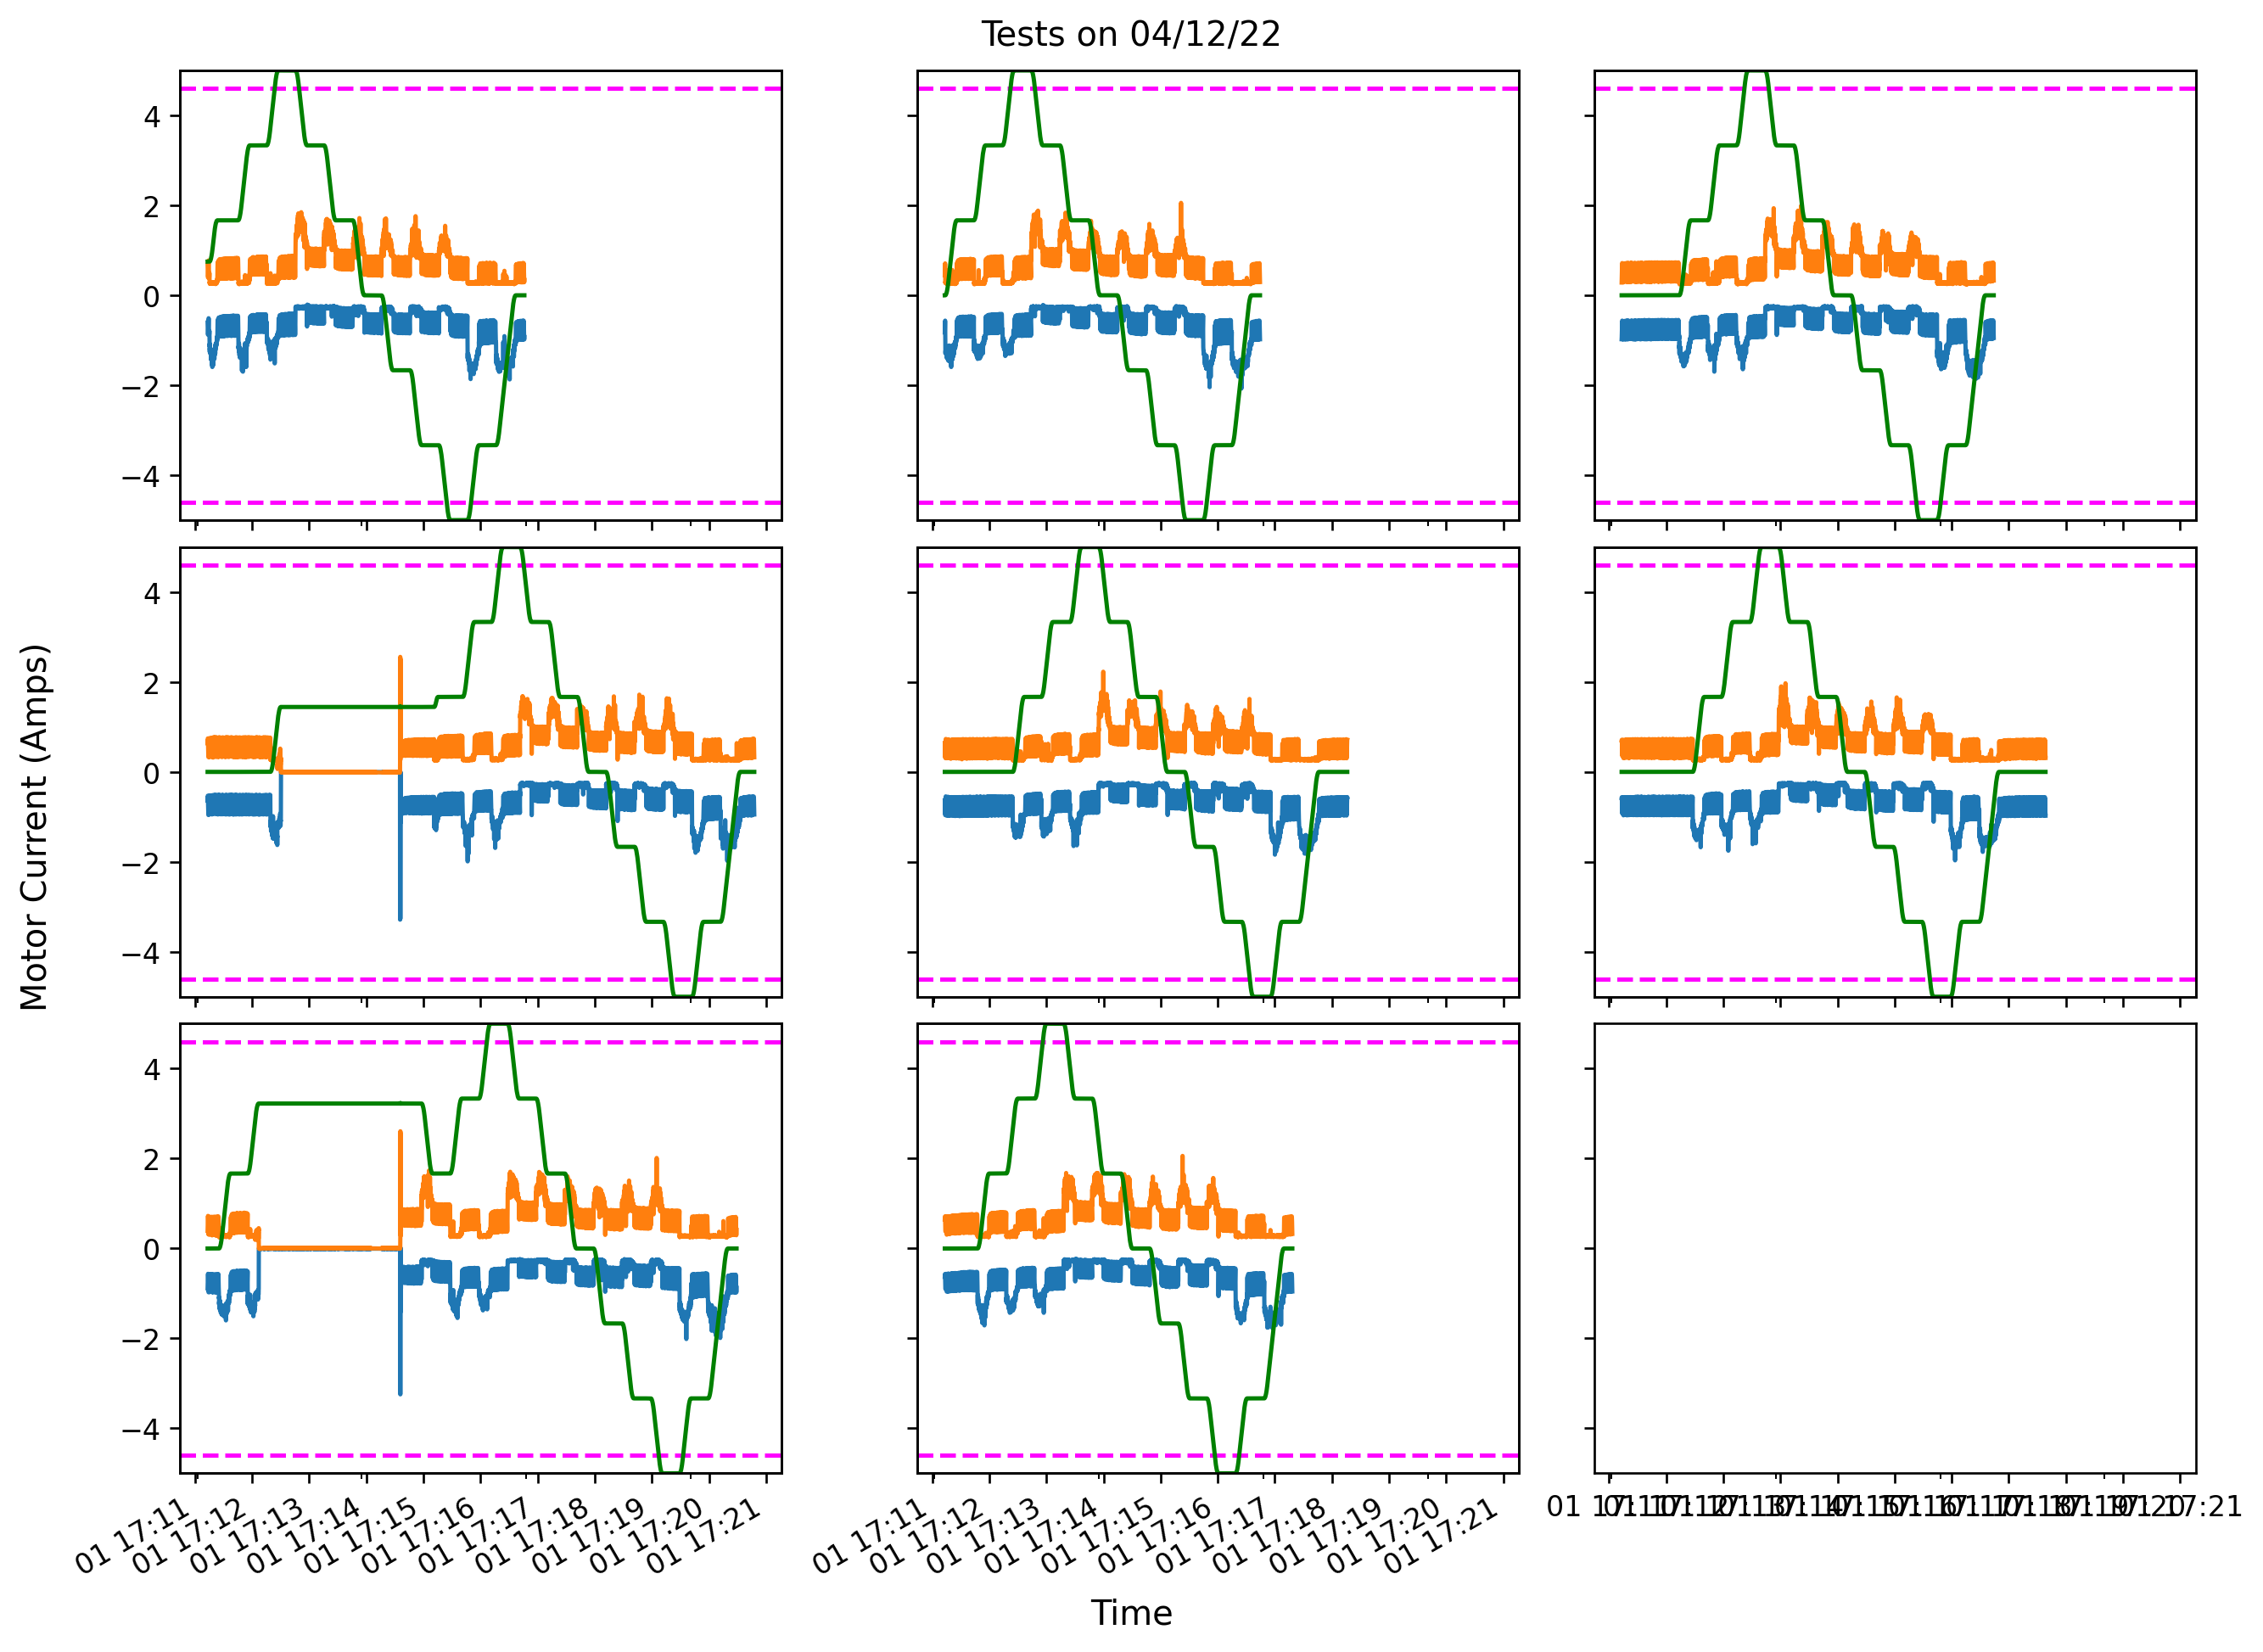

In [40]:
layout_3x3 = '''
ABC
DEF
GHI
'''

layout_3x4 = '''
ABC
DEF
GHI
JKL
'''

draw_rotator_tests('Tests on 03/01/22',layout_3x3, 0, 7)
draw_rotator_tests('Tests on 03/10/22',layout_3x4, 8, 18)
draw_rotator_tests('Tests on 04/06/22',layout_3x3, 19, 26)
draw_rotator_tests('Tests on 04/12/22',layout_3x3, 27, 34)